# Sentiment Analysis using NLP & Deep learning techniques

Team Members :

    - Darun Arumugham (110088300)
    - Varshitha Seralathan (110087938)

<img src="https://m.media-amazon.com/images/G/01/imdb/images/social/imdb_logo.png" alt="image info" />


The aim of the project is perform Sentiment analysis of the reviews submitted on IMDB. IMDB is an online database of information related to visual entertainments like movies, TV series etc. It is a popular medium for people to review and rate movies. IMDB ratings are considered as benchmark for success of multiple movies.

The dataset contains 50000 reviews, 25000 of each sentiment - positive (1) and negative (0).

## 1) Importing libraries and datasets

In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud,STOPWORDS
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense,Input, Embedding,LSTM,Dropout,Conv1D, MaxPooling1D, GlobalMaxPooling1D,Dropout,Bidirectional,Flatten,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
import transformers
import tokenizers

In [2]:
data=pd.read_csv("Data\IMDB Dataset.csv")

## 2) Data Exploration

In [3]:
data.head(5)

review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive

In [4]:
data.shape

(50000, 2)

In [5]:
data.isnull().sum()

review       0
sentiment    0
dtype: int64

<div class="alert alert-block alert-info"> <b>Observation </b>: Data does not contain any null  values </div>

In [6]:
data.duplicated().sum()

418

<div class="alert alert-block alert-info"> <b>Observation </b>: There are 418 duplicate reviews present in the dataset <div>

In [7]:
#view duplicate reviews
review = data['review']
duplicated_review = data[review.isin(review[review.duplicated()])].sort_values("review")
duplicated_review.head()

review sentiment
34058  "Go Fish" garnered Rose Troche rightly or wron...  negative
47467  "Go Fish" garnered Rose Troche rightly or wron...  negative
29956  "Three" is a seriously dumb shipwreck movie. M...  negative
31488  "Three" is a seriously dumb shipwreck movie. M...  negative
47527  "Witchery" might just be the most incoherent a...  negative

In [8]:
#drop duplicate reviews
data.drop_duplicates(inplace = True)

In [9]:
print('The dataset contains {} rows and {} columns after removing duplicates'.format(data.shape[0],data.shape[1]))

The dataset contains 49582 rows and 2 columns after removing duplicates


In [10]:
data.describe()

review sentiment
count                                               49582     49582
unique                                              49582         2
top     One of the other reviewers has mentioned that ...  positive
freq                                                    1     24884

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49582 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     49582 non-null  object
 1   sentiment  49582 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


C:\Users\Varshi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


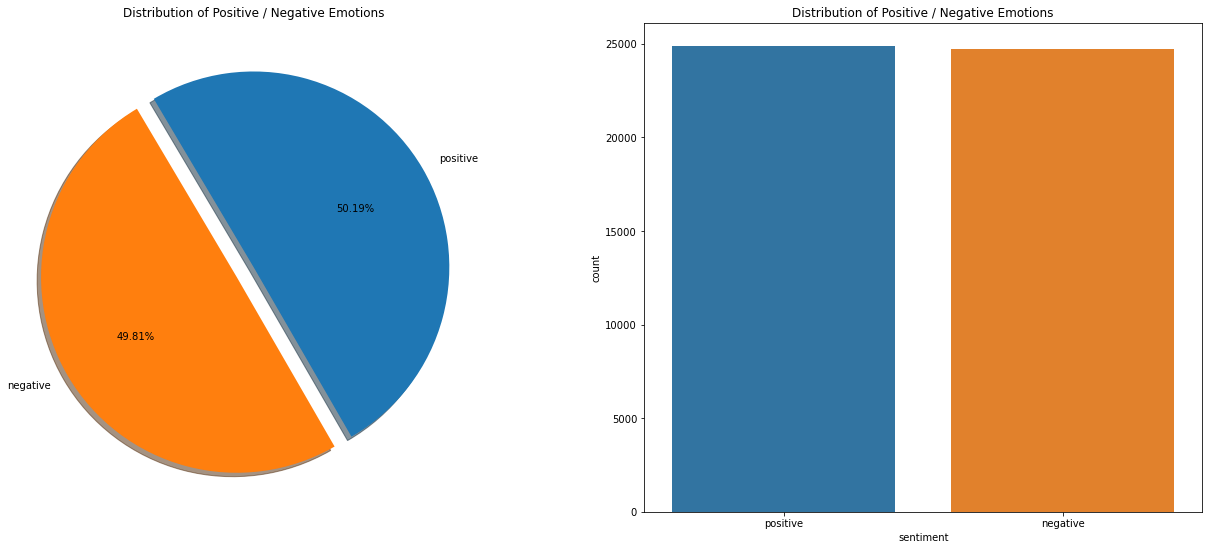

In [12]:
a , ax = plt.subplots(1,2,figsize=(22,9))
data['sentiment'].value_counts().plot.pie(explode=[0,0.1], autopct='%1.2f%%',ax=ax[0],shadow=True, startangle=300)
ax[0].set_title('Distribution of Positive / Negative Emotions')
ax[0].set_ylabel('')
sns.countplot('sentiment', data = data ,ax=ax[1])
ax[1].set_title('Distribution of Positive / Negative Emotions')
plt.show()

In [13]:
data['sentiment'].value_counts()

positive    24884
negative    24698
Name: sentiment, dtype: int64

<div class="alert alert-block alert-info"> <b>Observation </b>: Data contains equal amount of positive and negative reviews </div>

In [14]:
data.sentiment.replace("positive" , 1 , inplace = True)
data.sentiment.replace("negative" , 0 , inplace = True)
data.head()

review  sentiment
0  One of the other reviewers has mentioned that ...          1
1  A wonderful little production. <br /><br />The...          1
2  I thought this was a wonderful way to spend ti...          1
3  Basically there's a family where a little boy ...          0
4  Petter Mattei's "Love in the Time of Money" is...          1

    -Sample Checking

In [15]:
# sample positive movie review
data[data['sentiment']==1].sample(n=1)['review'].iloc[0]

"This film is based on a true story. The author of the novel bearing the same title, Einar Már Guðmundsson, had a brother, who turned mentally ill. I found this film very moving, following the main character's path down into illness, to see how he tries to cope with life after diagnosis, and how he makes friends at the mental institution, it all is very convincing. There are quite a few splendidly funny incidents also in the manuscript. The title of it gives nothing away concerning the story. You must watch it to understand ... and listen to the music, which is twisting and turning your heart and soul upside down and back as the film moves on. A must-see for everyone."

In [16]:
# sample negative review
data[data['sentiment']==0].sample(n=1)['review'].iloc[0]

"regardless of what anyone says, its a b-movie, and the effects are poorly done.. if you're a vampire fanatic, I suppose it would be OK, not 10 out of 10, you others here cant sincerely mean that?. we are to view this as a movie, not read it as a book, so the effects and characters are important, as well as the story. The story are good, but it doesn't carry the film, no wonder it has a low rating over all. I write this because I chose to see this movie when I saw some good reviews here on IMDb, but got severely disappointed. don't get me wrong, I thought the blade movies was awesome, and loved the underworld movies, but this characters aren't close. the make up on the vampires is poorly done, and the effects are worse. this sucks. I might not have gotten so disappointed if I had not read reviews here that told me how great it was. the reviewers must have had something to do with the production company or something, seriously, if you think this is awesome, you don't care about acting o

In [17]:
# word_count in reviews
word_counts = data['review'].apply(lambda x: len(x.split()))

word_counts.describe()

count    49582.000000
mean       231.350167
std        171.542020
min          4.000000
25%        126.000000
50%        173.000000
75%        281.000000
max       2470.000000
Name: review, dtype: float64

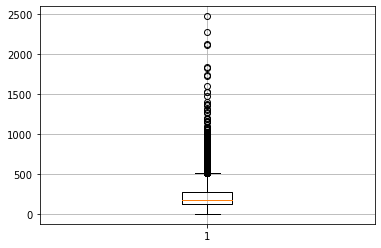

In [18]:
plt.boxplot(word_counts.values)
plt.grid(True)
plt.show()

<div class="alert alert-block alert-info"> <b>Observation </b>: Most of the reviews have words 200-350 </div>

In [19]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(data.review)

In [20]:
sentences=data['review']


In [21]:
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

{'the': 564474,
 'a': 304819,
 'and': 299760,
 'of': 281597,
 'to': 259895,
 'is': 201675,
 'in': 168738,
 'I': 131363,
 'that': 125878,
 'this': 112817}

<div class="alert alert-block alert-info"> <b>Observation </b>: It is evident that there are many stops words in the data which must be treated for better prediction</div>

(-0.5, 1599.5, 799.5, -0.5)

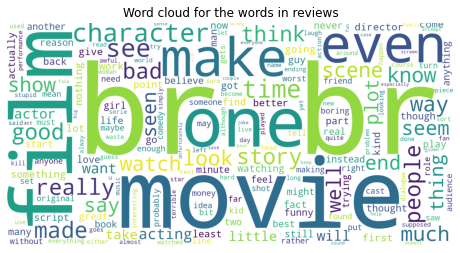

In [22]:
pos=' '.join(map(str,sentences[data['sentiment']==1]))
neg=' '.join(map(str,sentences[data['sentiment']==0]))
  
wordcloud1 = WordCloud(width = 1600, height = 800,
                background_color ='white',
                min_font_size = 10).generate(neg)



plt.figure(figsize=(8,8))
plt.imshow(wordcloud1)
plt.title('Word cloud for the words in reviews')
plt.axis('off')

<div class="alert alert-block alert-info"> <b>Observation </b>: Word cloud will be better with basic data preproccessing </div>

## 3) Data Preprocessing

### 1. Basic cleaning techniques

In [23]:
#Tokenization of text
tokenizer=Tokenizer()
#Setting English stopwords
stopword_list=nltk.corpus.stopwords.words('english')

In [24]:
def clean_text(text):
    '''
        Make text lowercase, remove text in square brackets,remove links,remove punctuation
        and remove words containing numbers.
    '''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text) # remove urls
    text = re.sub('<.*?>+', '', text)
    
    #Remove puncuations
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) # remove punctuation
    
    # Remove new lines
    text = re.sub('\n', '', text)
    
    #remove prediods  marks
    text = re.sub(r"[\.]*","",text)
    
    text = re.sub('\w*\d\w*', '', text)
    
    # Remove double spaces
    text = re.sub('  ',' ',text) 
    return text

In [25]:
data['review']=data['review'].apply(clean_text)

### 2) Removing html strips and noise text

In [26]:
#Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()
#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text
#Apply function on review column
data['review']=data['review'].apply(denoise_text)

### 3) Removing special characters

In [27]:
#Define function for removing special characters
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text
#Apply function on review column
data['review']=data['review'].apply(remove_special_characters)

In [28]:
data.head(10)

review  sentiment
0  one of the other reviewers has mentioned that ...          1
1  a wonderful little production the filming tech...          1
2  i thought this was a wonderful way to spend ti...          1
3  basically theres a family where a little boy j...          0
4  petter matteis love in the time of money is a ...          1
5  probably my alltime favorite movie a story of ...          1
6  i sure would like to see a resurrection of a u...          1
7  this show was an amazing fresh innovative idea...          0
8  encouraged by the positive comments about this...          0
9  if you like original gut wrenching laughter yo...          1

### 4) Removing stopwords and normalization

Stop words are very commonly used words (a, an, the, etc.) in the documents. These words do not really signify any importance as they do not help in distinguishing two documents.

In [29]:
# Tokenize and remove stopwords 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize,sent_tokenize
stopw = set(stopwords.words('english'))
print(stopw)
def filter_on_stopwords(data):
    word_tokens = word_tokenize(data)
    no_stopword_tokens = [token for token in word_tokens if token not in stopw]
    data = ' '.join(no_stopword_tokens)
    return data
data['review'] = data['review'].apply(filter_on_stopwords)

{"should've", 'yours', 'each', 'do', 'were', 'should', 'whom', 'm', 'who', 'further', 'ma', 'the', 'now', 'to', 'at', "wasn't", 're', 'can', "hadn't", 'hasn', 't', 'those', 'she', 'doesn', 'below', 'myself', 'his', 's', 'before', 'shouldn', "mightn't", 'doing', 'shan', 'did', 'won', 'been', 'from', 'until', 'as', 'they', 'it', 'in', 'above', 'and', "wouldn't", "weren't", "won't", 'herself', 'off', 'under', 'both', 'why', "hasn't", 'couldn', 'haven', 'weren', 'through', 'on', 'ourselves', 'some', 'how', 'y', 'ain', 'me', 'my', 'its', 'during', 'such', "you'll", 'didn', 'aren', 'hers', 'then', "you're", 'our', 'about', 'than', 'we', 'itself', "don't", 'a', 'isn', 'has', 'them', 'am', 'just', "shan't", 'that', 'for', 'down', 'most', 'after', 'd', "haven't", 'have', 'over', 'there', 'was', 'having', 'between', 'into', 'hadn', 'few', "shouldn't", 'against', 'while', 'of', 'wasn', 'again', 'mustn', 'own', 'o', 'yourselves', 'by', 'him', 'other', 'what', 'are', 'which', 'themselves', 'i', 'be

In [30]:
data.head(10)

review  sentiment
0  one reviewers mentioned watching oz episode yo...          1
1  wonderful little production filming technique ...          1
2  thought wonderful way spend time hot summer we...          1
3  basically theres family little boy jake thinks...          0
4  petter matteis love time money visually stunni...          1
5  probably alltime favorite movie story selfless...          1
6  sure would like see resurrection dated seahunt...          1
7  show amazing fresh innovative idea first aired...          0
8  encouraged positive comments film looking forw...          0
9  like original gut wrenching laughter like movi...          1

### 5) Stemming 

In [31]:
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer,WordNetLemmatizer, PorterStemmer, LancasterStemmer

sb = SnowballStemmer(language='english')
ps = PorterStemmer()
lm = LancasterStemmer()

s1 = "Programmers alltime favourite programming languages movie fairly generically"
w1 = word_tokenize(s1)
w2 = word_tokenize(s1)
w3 = word_tokenize(s1)

print("\n SnowBall Stemming: \n")  
for w in w1:
    print(w, ": ", sb.stem(w))
    
print("\n Porter Stemming: \n")
for w in w2:
    print(w, ": ", ps.stem(w))
    
print("\n Lancaster Stemming: \n ")  
for w in w3:
    print(w, ": ", lm.stem(w))


 SnowBall Stemming: 

Programmers :  programm
alltime :  alltim
favourite :  favourit
programming :  program
languages :  languag
movie :  movi
fairly :  fair
generically :  generic

 Porter Stemming: 

Programmers :  programm
alltime :  alltim
favourite :  favourit
programming :  program
languages :  languag
movie :  movi
fairly :  fairli
generically :  gener

 Lancaster Stemming: 
 
Programmers :  program
alltime :  alltim
favourite :  favourit
programming :  program
languages :  langu
movie :  movy
fairly :  fair
generically :  gen


<div class="alert alert-block alert-warning">
<b>Observation:</b> Snowball Stemmer cames out to be one of the best suited algorithm for my needs, but this totally depends on use case and dataset.
</div>

<div class="alert alert-block alert-danger">
<b>Conclusion :</b> In simple words, stemming technique only looks at the form of the word whereas lemmatization technique looks at the meaning of the word. It means after applying lemmatization, we will always get a valid word. So we will be skipping stemming and try lemmatization.
</div>

### 6) Lemmatization

In [32]:
from nltk.stem import WordNetLemmatizer
#Defining clean_text function
stop_words = set(stopwords.words("english")) 
lemmatizer = WordNetLemmatizer()
def clean_text(text):
    text = [lemmatizer.lemmatize(token) for token in text.split(" ")]
    text = [lemmatizer.lemmatize(token, "v") for token in text]
    text = [word for word in text if not word in stop_words]
    text = " ".join(text)
    return text

data['review']=data['review'].apply(lambda x: clean_text(x))

In [33]:
data.head(10)

review  sentiment
0  one reviewer mention watch oz episode youll ho...          1
1  wonderful little production film technique una...          1
2  think wonderful way spend time hot summer week...          1
3  basically family little boy jake think zombie ...          0
4  petter matteis love time money visually stun f...          1
5  probably alltime favorite movie story selfless...          1
6  sure would like see resurrection date seahunt ...          1
7  show amaze fresh innovative idea first air fir...          0
8  encourage positive comment film look forward w...          0
9  like original gut wrench laughter like movie y...          1

    - Label Encoding

In [34]:
sentences=data['review']
le=LabelEncoder()
data['sentiment']= le.fit_transform(data['sentiment'])

In [35]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(data.review)

### Most Commonly used words

In [36]:
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

{'movie': 98186,
 'film': 91432,
 'one': 52248,
 'make': 43641,
 'like': 42569,
 'see': 40283,
 'get': 35155,
 'time': 29506,
 'good': 28396,
 'character': 27339}

<div class="alert alert-block alert-success">
<b>After Preprocessing :</b> These are the most commonly used words in the reviews.
</div>

### Unigram analysis

In [37]:
def get_top_text_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [38]:
from sklearn.feature_extraction.text import CountVectorizer
import plotly.express as px

most_common_uni = get_top_text_ngrams(data.review,20,1)
most_common_uni = dict(most_common_uni)
temp = pd.DataFrame(columns = ["Common_words" , 'Count'])
temp["Common_words"] = list(most_common_uni.keys())
temp["Count"] = list(most_common_uni.values())
fig = px.bar(temp, x="Count", y="Common_words", title='Commmon Words in Text', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

### Bigrams

In [39]:
most_common_bi = get_top_text_ngrams(data.review,20,2)
most_common_bi = dict(most_common_bi)
temp = pd.DataFrame(columns = ["Common_words" , 'Count'])
temp["Common_words"] = list(most_common_bi.keys())
temp["Count"] = list(most_common_bi.values())
fig = px.bar(temp, x="Count", y="Common_words", title='Commmon Bigrams in Text', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

### Trigrams

In [40]:
most_common_tri = get_top_text_ngrams(data.review,20,3)
most_common_tri = dict(most_common_tri)
temp = pd.DataFrame(columns = ["Common_words" , 'Count'])
temp["Common_words"] = list(most_common_tri.keys())
temp["Count"] = list(most_common_tri.values())
fig = px.bar(temp, x="Count", y="Common_words", title='Commmon Trigrams in Text', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

### Word Cloud for positive review ater data preprocessing

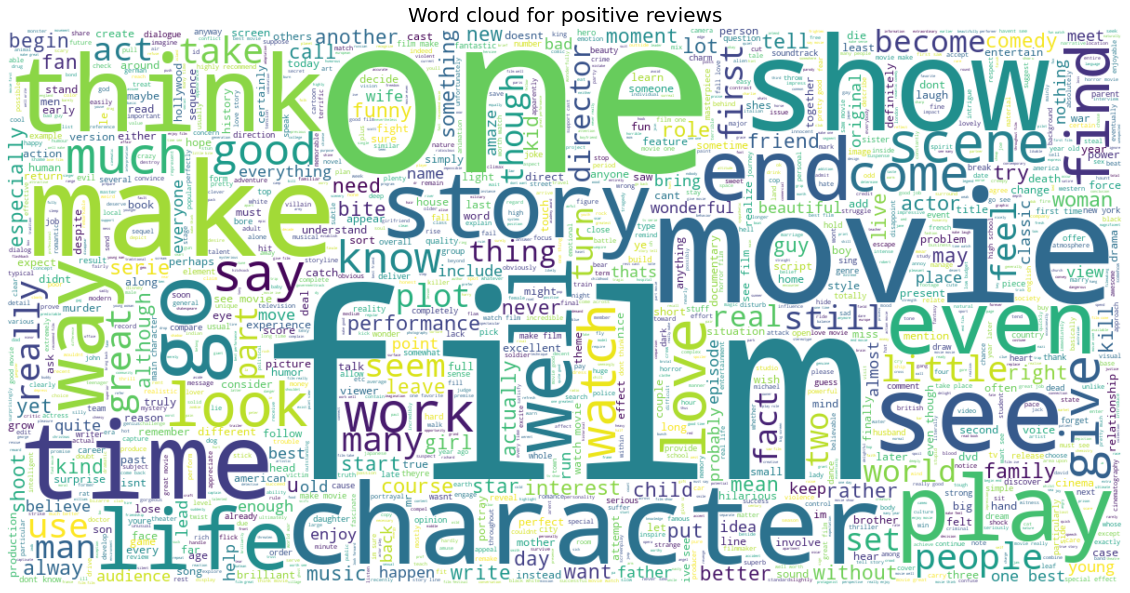

In [41]:
#word cloud for positive reviews
positive_data = data[data.sentiment == 1]['review']
positive_data_string = ' '.join(positive_data)
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000, width=1200, height=600,background_color="white").generate(positive_data_string)
plt.imshow(wc , interpolation = 'bilinear')
plt.axis('off')
plt.title('Word cloud for positive reviews',fontsize = 20)
plt.show()

### Word Cloud for negative reviews

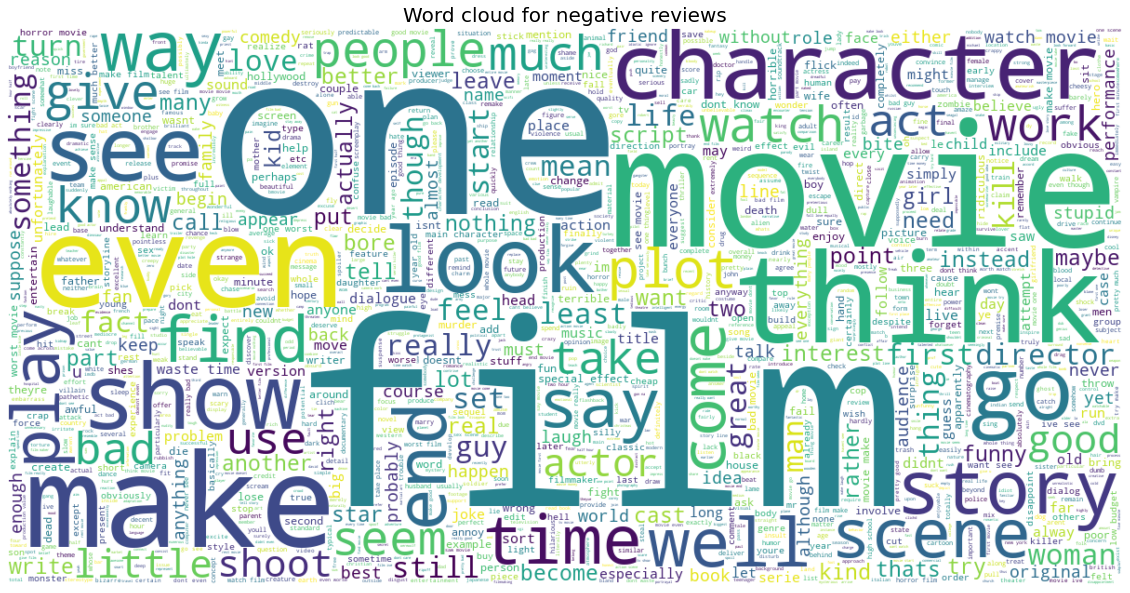

In [42]:
#word cloud for negative reviews
negative_data = data[data.sentiment == 0]['review']
negative_data_string = ' '.join(negative_data)
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000, width=1200, height=600,background_color="white").generate(negative_data_string)
plt.imshow(wc , interpolation = 'bilinear')
plt.axis('off')
plt.title('Word cloud for negative reviews',fontsize = 20)
plt.show()

<div class="alert alert-block alert-success">
<b>After preproceesing :</b> Clearly the new text preprocessing method resulted in much more cleaner reviews, the prominent "br" tag that has massive occurence is not visible anymore.
</div>

### Distribution of number of words per reviews

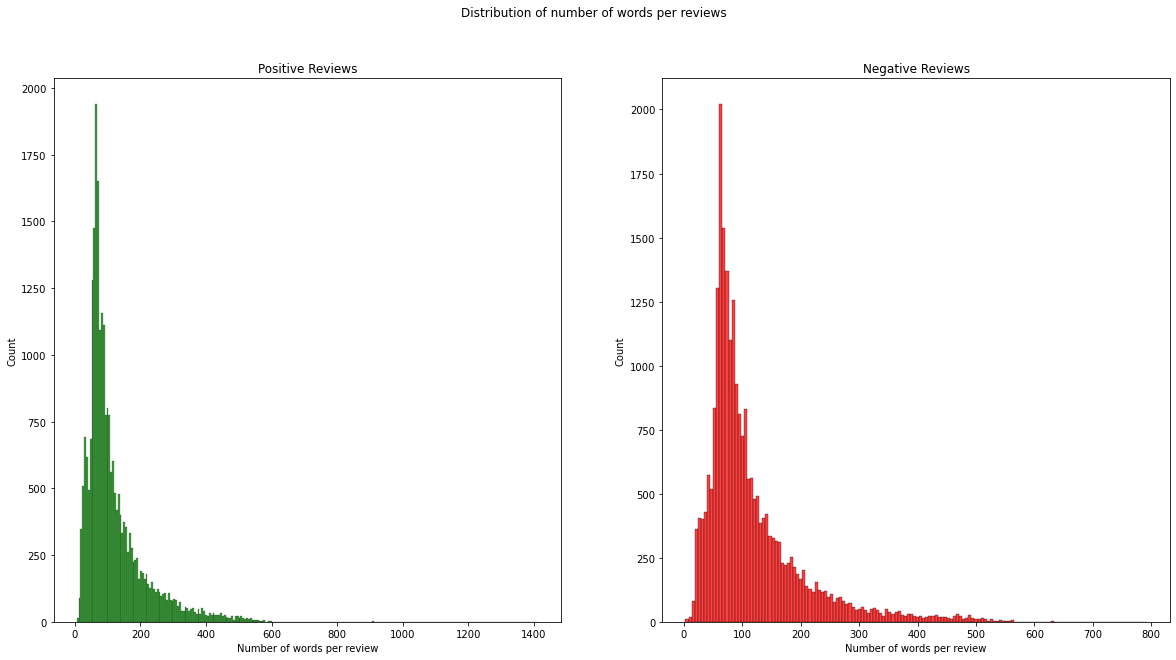

In [43]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
word = positive_data.str.split().apply(lambda x : len(x) )
sns.histplot(word, ax=ax1,color='green')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('Number of words per review')
word = negative_data.str.split().apply(lambda x :len(x) )
sns.histplot(word,ax=ax2,color='red')
ax2.set_title('Negative Reviews')
ax2.set_xlabel('Number of words per review')
fig.suptitle('Distribution of number of words per reviews')
plt.show()

### Distribution of average word length in each review

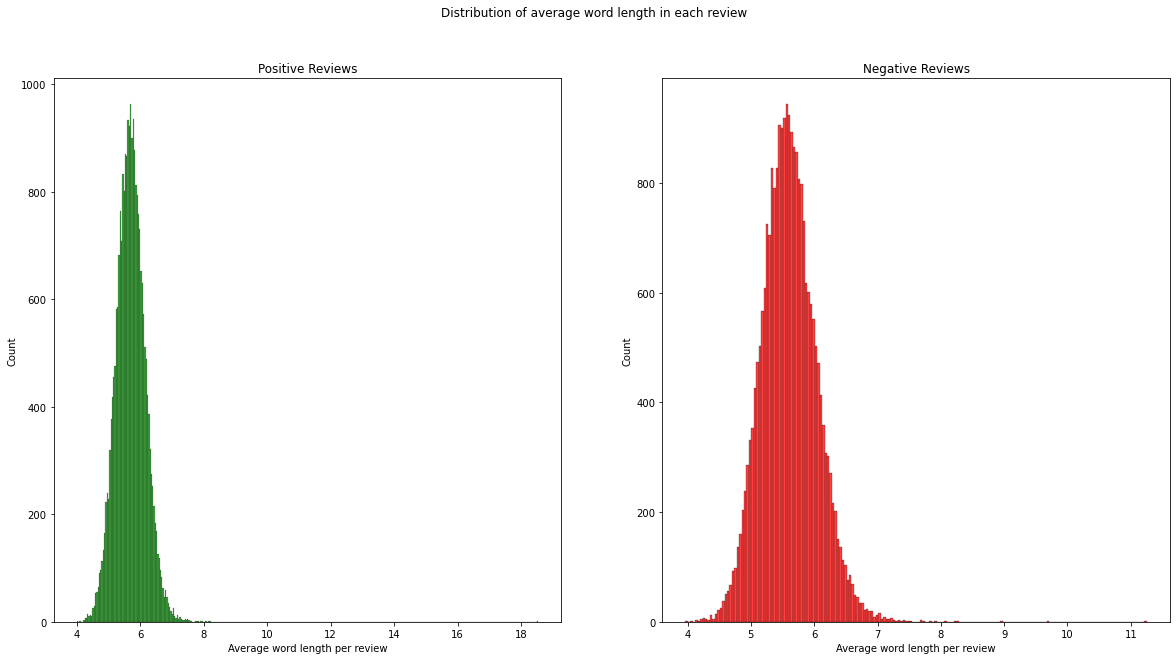

In [44]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
word = positive_data.str.split().apply(lambda x : [len(i) for i in x] )
sns.histplot(word.map(lambda x: np.mean(x)), ax=ax1,color='green')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('Average word length per review')
word = negative_data.str.split().apply(lambda x : [len(i) for i in x] )
sns.histplot(word.map(lambda x: np.mean(x)),ax=ax2,color='red')
ax2.set_title('Negative Reviews')
ax2.set_xlabel('Average word length per review')
fig.suptitle('Distribution of average word length in each review')
plt.show()

## 5) Model Building

In [45]:
train, test= train_test_split(data, test_size=0.2, random_state=42)
Xtrain, ytrain = train['review'], train['sentiment']
Xtest, ytest = test['review'], test['sentiment']

In [46]:
#set up the tokenizer
MAX_VOCAB_SIZE = 10000
tokenizer = Tokenizer(num_words = MAX_VOCAB_SIZE,oov_token="<oov>")
tokenizer.fit_on_texts(Xtrain)
word_index = tokenizer.word_index
#print(word_index)
V = len(word_index)
print("Vocabulary of the dataset is : ",V)

Vocabulary of the dataset is :  165300


In [47]:
##create sequences of reviews
seq_train = tokenizer.texts_to_sequences(Xtrain)
seq_test =  tokenizer.texts_to_sequences(Xtest)

In [48]:
#choice of maximum length of sequences
seq_len_list = [len(i) for i in seq_train + seq_test]

#if we take the direct maximum then
max_len=max(seq_len_list)
print('Maximum length of sequence in the list: {}'.format(max_len))

Maximum length of sequence in the list: 1412


In [49]:
# when setting the maximum length of sequence, variability around the average is used.
max_seq_len = np.mean(seq_len_list) + 2 * np.std(seq_len_list)
max_seq_len = int(max_seq_len)
print('Maximum length of the sequence when considering data only two standard deviations from average: {}'.format(max_seq_len))

Maximum length of the sequence when considering data only two standard deviations from average: 295


In [50]:
perc_covered = np.sum(np.array(seq_len_list) < max_seq_len) / len(seq_len_list)*100
print('The above calculated number coveres approximately {} % of data'.format(np.round(perc_covered,2)))

The above calculated number coveres approximately 94.51 % of data


So we can use this number for our maxlen parameter

In [51]:
#create padded sequences
pad_train=pad_sequences(seq_train,truncating = 'post', padding = 'pre',maxlen=max_seq_len)
pad_test=pad_sequences(seq_test,truncating = 'post', padding = 'pre',maxlen=max_seq_len)

In [52]:
#Splitting training set for validation purposes
Xtrain,Xval,ytrain,yval=train_test_split(pad_train,ytrain,
                                             test_size=0.2,random_state=10)

In [53]:
def lstm_model(Xtrain,Xval,ytrain,yval,V,D,maxlen,epochs):

    print("----Building the model----")
    i = Input(shape=(maxlen,))
    x = Embedding(V + 1, D,input_length = maxlen)(i)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Conv1D(32,5,activation = 'relu')(x)
    x = Dropout(0.3)(x)
    x = MaxPooling1D(2)(x)
    x = Bidirectional(LSTM(128,return_sequences=True))(x)
    x = LSTM(64)(x)
    x = Dropout(0.5)(x)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(i, x)
    model.summary()

    #Training the LSTM
    print("----Training the network----")
    model.compile(optimizer= Adam(0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])
    

    r = model.fit(Xtrain,ytrain, 
                  validation_data = (Xval,yval), 
                  epochs = epochs, 
                  verbose = 2,
                  batch_size = 32)
                  #callbacks = callbacks
    print("Train score:", model.evaluate(Xtrain,ytrain))
    print("Validation score:", model.evaluate(Xval,yval))
    n_epochs = len(r.history['loss'])
    
    return r,model,n_epochs 

In [54]:
D = 64 #embedding dims
epochs = 3
r,model,n_epochs = lstm_model(Xtrain,Xval,ytrain,yval,V,D,max_seq_len,epochs)

----Building the model----
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 295)]             0         
                                                                 
 embedding (Embedding)       (None, 295, 64)           10579264  
                                                                 
 batch_normalization (BatchN  (None, 295, 64)          256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 295, 64)           0         
                                                                 
 conv1d (Conv1D)             (None, 291, 32)           10272     
                                                                 
 dropout_1 (Dropout)         (None, 291, 32)           0         
                                  

## 6) Model Evaluation

In [55]:
def plotLearningCurve(history,epochs):
  epochRange = range(1,epochs+1)
  fig , ax = plt.subplots(1,2,figsize = (10,5))
  
  ax[0].plot(epochRange,history.history['accuracy'],label = 'Training Accuracy')
  ax[0].plot(epochRange,history.history['val_accuracy'],label = 'Validation Accuracy')
  ax[0].set_title('Training and Validation accuracy')
  ax[0].set_xlabel('Epoch')
  ax[0].set_ylabel('Accuracy')
  ax[0].legend()
  ax[1].plot(epochRange,history.history['loss'],label = 'Training Loss')
  ax[1].plot(epochRange,history.history['val_loss'],label = 'Validation Loss')
  ax[1].set_title('Training and Validation loss')
  ax[1].set_xlabel('Epoch')
  ax[1].set_ylabel('Loss')
  ax[1].legend()
  fig.tight_layout()
  plt.show()


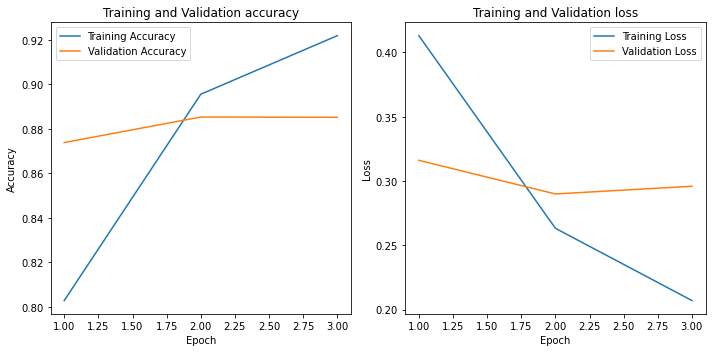

In [56]:
#Plot accuracy and loss
plotLearningCurve(r,n_epochs)

310/310 [==============================] - 26s 78ms/step


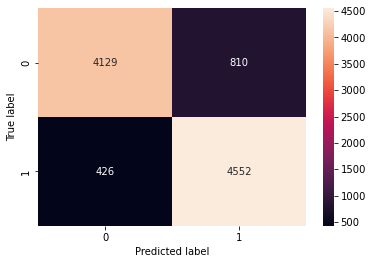

In [57]:
#Generate predictions for the test dataset
ypred = model.predict(pad_test)
ypred = ypred>0.5
#Get the confusion matrix
cf_matrix = confusion_matrix(ytest, ypred)
sns.heatmap(cf_matrix,annot = True,fmt ='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

## 7) Conclusion

Sentiment analysis, often known as opinion mining, is the method of extracting opinions from text data and categorizing them as either positive, negative, or neutral. 
In this study, the IMDb movie reviews are preprocessed and categorized using a Long Short-Term Memory classifier and Adam optimizer. A total of 40k reviews—20k for positive and 20k for negative—are taken into account for training. Ten thousand reviews from the dataset are tested. 

<div class="alert alert-block alert-success">
The best accuracy reached by the proposed approach, according to the results, is 95.92% for training data and 88.63% for validation data.
</div>